### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/cluster">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')

In [ ]:
import sys
!git clone 'http://github.com/Nak007/cluster.git'
sys.path.append('/content/cluster')

Install `factor_analyzer`

In [ ]:
!pip install factor_analyzer

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import (QuantileTransformer, 
                                   StandardScaler)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format =  '{:,.2f}'.format

## Example

Import following libraries:
- `varclus` 
- `Univariate`
- `cluster_validity`
- `cluster_visualization`
- `Factor_Analysis`

In [3]:
from varclus import *
from Univariate import *
from cluster_validity import *
from cluster_visualization import *
from Factor_Analysis import *

### <font color="green" size=5> Make data for clustering </font>

Simulate dataset from `sklearn.datasets.make_blobs`. [Reference](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples   = 2000, 
                  n_features  = 30, 
                  centers     = 4, 
                  cluster_std = [2.1, 2.8, 4, 1.5], 
                  center_box  = (-10, 10), 
                  random_state= 200)

X = pd.DataFrame(X, columns=['feature_{}'.format(str(n).zfill(2)) 
                             for n in range(1,X.shape[1]+1)])

### <font color="green" size=5> Cap Outliers </font>

`UnivariateOutliers` determines univariate outliers within one variable at a time. Any identified outlier, is capped to the lower/upper value.

In [5]:
outlier = UnivariateOutliers().fit(X)

Excluded variables

In [8]:
outlier.exclude

{'non_numeric': [], 'min_numeric': []}

In [9]:
outlier.info.head(5)

,variable,lower,upper,n_lower,n_upper,n_outlier,n_notnan,p_outlier
0,feature_22,-12.71,18.93,0,0,0,2000,0.00
1,feature_23,-18.71,23.05,0,0,0,2000,0.00
2,feature_06,-20.00,24.63,0,0,0,2000,0.00
3,feature_25,-13.77,12.18,6,0,6,2000,0.00
4,feature_15,-19.02,20.63,0,0,0,2000,0.00


In [10]:
X = outlier.capped_X

### <font color="green" size=5> Standardization </font>

Simulate dataset from `sklearn.preprocessing.StandardScaler`. Reference: [ [1](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) ]

In [11]:
Scaler = StandardScaler(with_mean=True, with_std=True).fit(X)
X_std  = pd.DataFrame(Scaler.transform(X), columns=X.columns)

### <font color="green" size=5> Variable Clustering </font>

`VariableClustering` performs variable clustering with a hierarchical structure, and it is often used as a dimension reduction algorithm.

In [12]:
vc = VariableClustering(maxclus=20, maxeigval2=0.6).fit(X_std)

In [13]:
vc.info

,N_Vars,Eigval1,Eigval2,VarProp,min_RSO,max_RSN,max_RSr
Cluster,,,,,,,
1,5,3.73,0.47,0.75,0.64,0.56,0.75
2,8,6.41,0.44,0.80,0.75,0.50,0.48
3,3,2.44,0.35,0.81,0.76,0.56,0.54
4,3,2.62,0.25,0.87,0.84,0.41,0.28
5,2,1.69,0.31,0.84,0.84,0.45,0.28
6,3,2.49,0.33,0.83,0.78,0.64,0.35
7,3,2.21,0.42,0.74,0.72,0.53,0.52
8,3,2.47,0.30,0.82,0.80,0.64,0.44


`vc.r2` shows how the variables are clustered. It displays the R-square value of each variable with its own cluster and the R-square value with its nearest cluster. The R-square value for a variable with the nearest cluster should be low if the clusters are well separated. The last column displays the ratio of $(1-R^{2}_{own})/(1-R^{2}_{nearsest})$ for each variable. Small values of this ratio indicate good clustering.

In [14]:
vc.r2.head(10)

RS_Own  RS_NC  RS_Ratio
Cluster Variable                           
1       feature_19    0.85   0.49      0.29
        feature_13    0.76   0.38      0.39
        feature_04    0.82   0.54      0.40
        feature_21    0.64   0.40      0.60
        feature_26    0.67   0.56      0.75
2       feature_01    0.86   0.33      0.21
        feature_15    0.84   0.31      0.23
        feature_18    0.81   0.26      0.25
        feature_16    0.80   0.24      0.26
        feature_03    0.81   0.37      0.31

We can use `cluster_matrix` to visualize results from `VariableClustering` through a matrix of scatter plots.

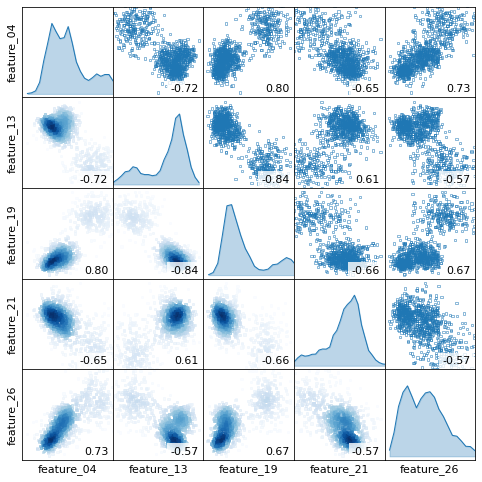

In [15]:
random_cluster = 1 # or np.random.randint(1, len(vc.info))
index = vc.clus_corr.index.get_level_values(0)==random_cluster
index = vc.clus_corr.loc[index].index.get_level_values(1)
axes = cluster_matrix(X_std[index].copy(), off_diagonal="both")

Let's select variable, with the lowest **RS_Ratio** from each **Cluster**.

In [16]:
vc_columns = vc.r2.reset_index().groupby('Cluster').first()["Variable"].values
X_std = X_std[vc_columns].copy()

In [17]:
X_std.head()

,feature_19,feature_01,feature_11,feature_23,feature_02,feature_28,feature_24,feature_07
0,0.04,1.07,1.78,0.89,-1.23,0.50,-0.13,-0.49
1,-0.36,0.99,1.65,0.47,-1.23,0.21,-0.58,-0.56
2,1.69,-0.51,-0.86,0.80,-0.71,0.53,1.03,-0.17
3,-0.52,0.98,1.60,0.45,-0.72,0.39,0.13,-1.11
4,-0.57,0.82,1.04,0.73,-1.05,1.04,0.12,-0.42


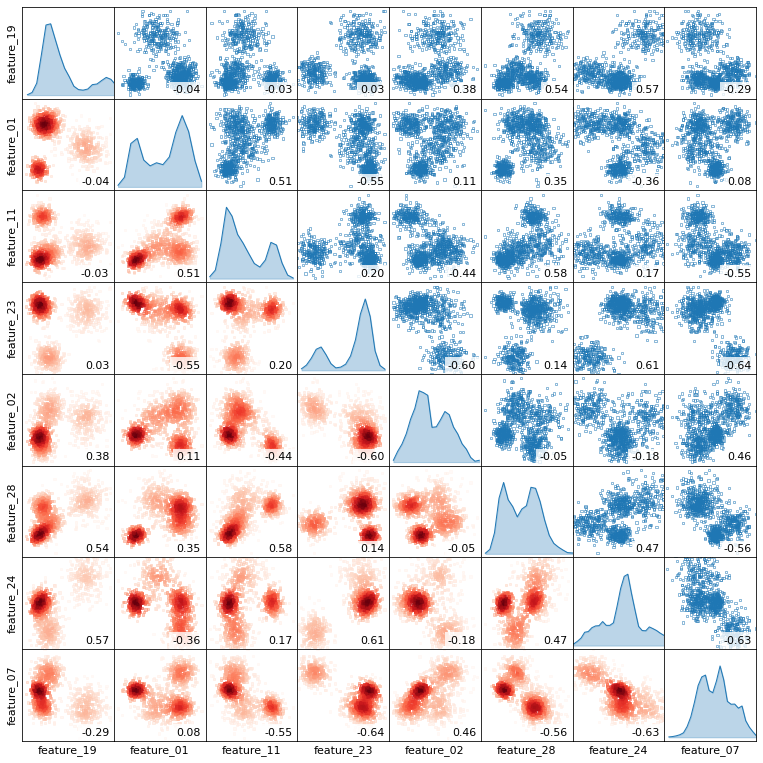

In [18]:
axes = cluster_matrix(X_std.copy(), off_diagonal="both", 
                      scatter_kwds=dict(cmap="Reds"))

### <font color="green" size=5> Data Suitability </font>

**Bartlett's Sphericity** tests the hypothesis, $H_{0}$ that the correlation matrix ($n$ by $n$) is equal to the identity matrix $\bf{I_{n}}$, which would indicate that your variables are unrelated and therefore unsuitable for structure detection.

In [19]:
Cal_Bartlett(X_std)

BartlettTest(chisq=11431.155883781583, df=28.0, pvalue=0.0)

**The Kaiser-Meyer-Olkin Measure of Sampling Adequacy** is a statistic that indicates the proportion of variance in variables that might be caused by underlying factors. High values (close to 1.0) generally indicate that a factor analysis may be useful with your data. If the value is less than 0.50, the results of the factor analysis probably won't be very useful. Reference: [ [1](https://www.ibm.com/docs/en/spss-statistics/23.0.0?topic=detection-kmo-bartletts-test) ]

$KMO = \frac{\sum\sum_{i \ne j}r^{2}_{ij}}{\sum\sum_{i \ne j}r^{2}_{ij} + \sum\sum_{i \ne j}a^{2}_{ij}}$ 

where $r_{ij}$ is a correlation between $x_{i}$, and $x_{j}$ and $a_{ij}$ is a partial correlation between $x_{i}$ and $x_{j}$; $i \ne j$

In [20]:
MSATest, KMOTest = Cal_KMOScore(X_std)

In [21]:
KMOTest

KMOTest(Score=0.7151705968290101, Corr=9.83143859603399, PartialCorr=3.915545186053163)

**Measure of Sampling Adequacy** is a statistic that indicates the proportion of variance in $x_{i}$ $(i = 1,2,\ldots ,k)$ that might be caused by underlying factors. 

$MSA_{i} = \frac{\sum_{i \ne j}r^{2}_{ij}}{\sum_{i \ne j}r^{2}_{ij} + \sum_{i \ne j}a^{2}_{ij}}$ 

In [22]:
MSATest.Score

array([0.58032538, 0.55697787, 0.66959434, 0.70007628, 0.73258349,
       0.77158099, 0.7940603 , 0.85185422])

**Squared Multiple Correlation coefficient** (SMC), $R^{2}$, measures the proportion of total variance on the variables, $x_{i}$, that is accounted for by a set of $k-1$ predictors, 
$X$ = {$x_{1}, x_{2},\ldots,x_{k}$}, and $x_{i}\notin X$. It provides an estimate for the overall predictive power of a set of predictors. Low $R^{2}_{i}$ should not be included in factor analysis as it represents a low correlation between $x_{i}$ and other $X$ e.g. $R^{2}< 0.5$.

In [23]:
Cal_SMC(X_std).T

,feature_19,feature_01,feature_11,feature_23,feature_02,feature_28,feature_24,feature_07
SMC,0.68,0.73,0.72,0.78,0.62,0.68,0.71,0.71


### <font color="green" size=5> Factor Extraction (Dimension Reduction) </font>

`PrincipalComponents` performs dimension reduction algorithm so-called Principal Component Analysis (PCA) on the correlation of X.

In [24]:
PCF = PrincipalComponents(minprop=0.8, mineigval=1.0).fit(X_std)

In order to decide which factor(s) can be dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues ($\lambda$). The factors or eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data. Those are the ones to be dropped. In order to do so, the common approach is to rank the eigenvalues ($\lambda$) from highest to lowest and choose the top `k` eigenvectors, whose value is above the minimum threshold e.g. 1.

Alternatively, summation of eigenvalues represents a proportion of variance that can be used as an indicator to decide an appropriate number of eigenvectors. First we rank eigenvectors by their corresponding eigenvalues ($\lambda$) from highest to lowest, and choose `k` eigenvectors, whose cumulative proportion of variance is above or equal to threshold e.g. 0.80 (80%).

Attribute: `variances`

In [25]:
PCF.variances

,Eigenvalues,% Variance,Cumulative %
Factor,,,
PC1,3.26,0.41,0.41
PC2,1.99,0.25,0.66
PC3,1.75,0.22,0.87
PC4,0.26,0.03,0.91
PC5,0.23,0.03,0.94
PC6,0.22,0.03,0.96
PC7,0.16,0.02,0.98
PC8,0.14,0.02,1.00


We can quantify how much of the variance of a given PC is explained by a given original variable by finding the correlation coefficient between variables and PCs. This could be done conventionally. However, if PCA is done on the correlations, the following approach is also applicable. $PC_{k}$ is associated with an eigenvector $\hat{X}_{k}$ and the corresponding eigenvalue $\lambda_{k}$. A loadings vector $\hat{L}_{k}$ is given by $\hat{L}_{i} = \hat{X}_{k}\sqrt{\lambda_{k}}$. Its elements are correlations of this PC with the respective original variables.

The communality (`communalities`)  is the sum of the squared component loadings (correlation) up to the number of components that gets extracted.

In [26]:
PCF.communalities

Extraction                      
                  PC1  PC2  PC3 Communality
feature_19       0.16 0.07 0.66        0.90
feature_01       0.02 0.80 0.09        0.91
feature_11       0.34 0.29 0.26        0.89
feature_23       0.56 0.33 0.02        0.90
feature_02       0.26 0.09 0.50        0.85
feature_28       0.45 0.37 0.03        0.86
feature_24       0.64 0.03 0.18        0.85
feature_07       0.82 0.00 0.01        0.83
Total            3.26 1.99 1.75        6.99

Apply the dimensionality reduction on X.

In [27]:
PC = PCF.transform(X_std, 3)
PC.head(5)

,PC1,PC2,PC3
0,-1.59,0.98,-1.66
1,-1.03,0.91,-1.98
2,-1.41,-0.71,1.41
3,-1.48,0.96,-1.56
4,-1.40,0.73,-1.42


Visualize all selected principal components.

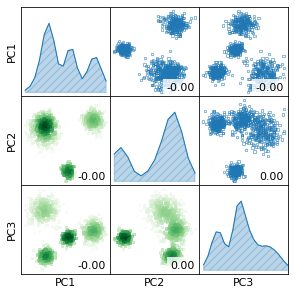

In [28]:
axes = cluster_matrix(PC.copy(), off_diagonal="both",
                      scatter_kwds=dict(cmap="Greens"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=True)

### <font color="green" size=5> Factor Rotation </font>

PCA often needs rotation for easier interpretation. Factor rotation tries to maximize variance of the squared loadings in each factor so that each factor has only a few variables with large loadings and many other variables with low loadings. References: [ [1](https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html#factor-analyzer-analyze-module) ], and [ [2](https://stats.idre.ucla.edu/spss/seminars/efa-spss/) ]. 

Rotation Methods
- orthogonal : {"varimax", "equamax", "quartimax"}
- oblique : {"promax", "oblimax", "oblimin", "quartimin"}

In [29]:
from factor_analyzer import FactorAnalyzer
fa_estimator = FactorAnalyzer(n_factors=3, method="principal", rotation="varimax").fit(X_std)

`FactorRotation` provides statistical information towards interpretation of factor loadings, specific variances, and communalities

In [30]:
rotate = FactorRotation().fit(fa_estimator, X_std.columns)

Variance explained by corresponding rotated factors. Just like in PCA the more factors get extracted, the less variance explained by each successive factor. Moreover, we notice that the total variance from rotation given the same number of factors, remains unchanged. This is due to **method** i.e. **minres**, **ml**, or **principal**, which dictates the initial variance (common, and unique) for algorithm to begin with.

In [31]:
rotate.variances

Initial                         Extraction                        
     Total % Variance Cumulative %      Total % Variance Cumulative %
F1    3.26       0.41         0.41       2.71       0.34         0.34
F2    1.99       0.25         0.66       2.23       0.28         0.62
F3    1.75       0.22         0.87       2.05       0.26         0.87
F4    0.26       0.03         0.91        nan        nan          nan
F5    0.23       0.03         0.94        nan        nan          nan
F6    0.22       0.03         0.96        nan        nan          nan
F7    0.16       0.02         0.98        nan        nan          nan
F8    0.14       0.02         1.00        nan        nan          nan

The elements are squared loadings, which represent the variance of each item that can be explainded by the corresponding factor. 

In [32]:
rotate.communalities

Extraction                                 
                   F1   F2   F3 Communality Uniqueness
feature_19       0.02 0.87 0.00        0.90       0.10
feature_01       0.17 0.01 0.73        0.91       0.09
feature_11       0.16 0.00 0.72        0.89       0.11
feature_23       0.82 0.03 0.04        0.90       0.10
feature_02       0.69 0.12 0.04        0.85       0.15
feature_28       0.02 0.44 0.39        0.86       0.14
feature_24       0.29 0.55 0.01        0.85       0.15
feature_07       0.53 0.20 0.10        0.83       0.17
Total            2.71 2.23 2.05        6.99       1.01

Correlation of each item with the corresponding factor.

Use `create_cmap(colors=None)` to create matplotlib.colors.Colormap (Colormaps).

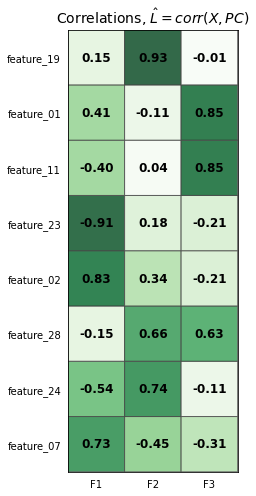

In [33]:
ax = plt.subplots(figsize=(3.5,7))[1]
ax = rotate.plotting(value="loading", ax=ax, cmap="Greens")

Residual variances that cannot be explained by factors. These values should be close zero in absolute term.

RMSR = 0.038


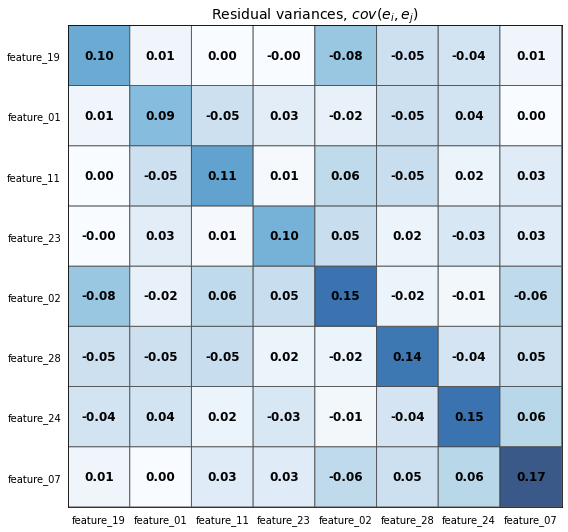

In [34]:
print("RMSR = {:,.3f}".format(rotate.rmsr))
ax = rotate.plotting(value="unique")

Apply the dimensionality reduction on X.

In [35]:
n_factors = fa_estimator.n_factors
RotatedFactors = pd.DataFrame(fa_estimator.transform(X_std))
RotatedFactors.columns = [f"F{n+1}" for n in range(n_factors)]
RotatedFactors.head(5)

,F1,F2,F3
0,-0.87,-0.34,1.40
1,-0.75,-0.73,1.38
2,-0.41,1.18,-0.68
3,-0.79,-0.33,1.34
4,-0.80,-0.30,1.14


Visualize all selected principal components.

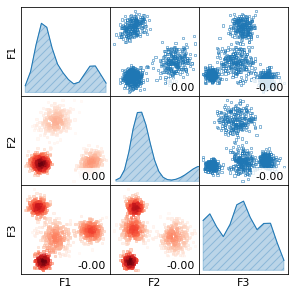

In [36]:
axes = cluster_matrix(RotatedFactors.copy(), off_diagonal="both",
                      scatter_kwds=dict(cmap="Reds"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=True)

### <font color="green" size=5> Clustering </font>

Using K-means algorithm from `sklearn.cluster.KMeans`. Reference: [ [1](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) ], and other algorithms [ [2](https://github.com/Nak007/fuzzy) ]

In [37]:
from sklearn.cluster import KMeans

labels = np.vstack([KMeans(n_clusters=n, random_state=99)
                    .fit_predict(RotatedFactors) for n in range(1,11)]).T

In [38]:
labels

array([[0, 1, 0, ..., 3, 1, 2],
       [0, 1, 0, ..., 3, 7, 4],
       [0, 1, 0, ..., 0, 5, 6],
       ...,
       [0, 0, 2, ..., 2, 3, 0],
       [0, 1, 0, ..., 3, 7, 4],
       [0, 1, 1, ..., 1, 2, 1]], dtype=int32)

### <font color="green" size=5> Clustering Validation </font>

`cluster_validity`. Reference: [ [1](https://github.com/Nak007/cluster-validity) ] 

- Elbow method (elbow_index)
- WB-index (wb_index)
- Calinski-Harabasz (calinski_harabasz)
- Hartigan (hartigen_index)
- Silhouette (silhouette)
- Gap statistic (gap_statistics)

In [ ]:
data = RotatedFactors.values.copy()

# All plotting methods.
methods = {"Elbow" : (elbow_index, None, plot_elbow), 
           "WB-index" : (wb_index, None, plot_wb), 
           "Calinski-Harabasz" : (calinski_harabasz, None, plot_ch),
           "Hartigan" : (hartigen_index, None, plot_hartigan),
           "Silhouette" : (silhouette, None, plot_silhouette),
           "Gap-statistic" : (gap_statistics, dict(n_bootstrap=5, random_state=0), plot_gap)}

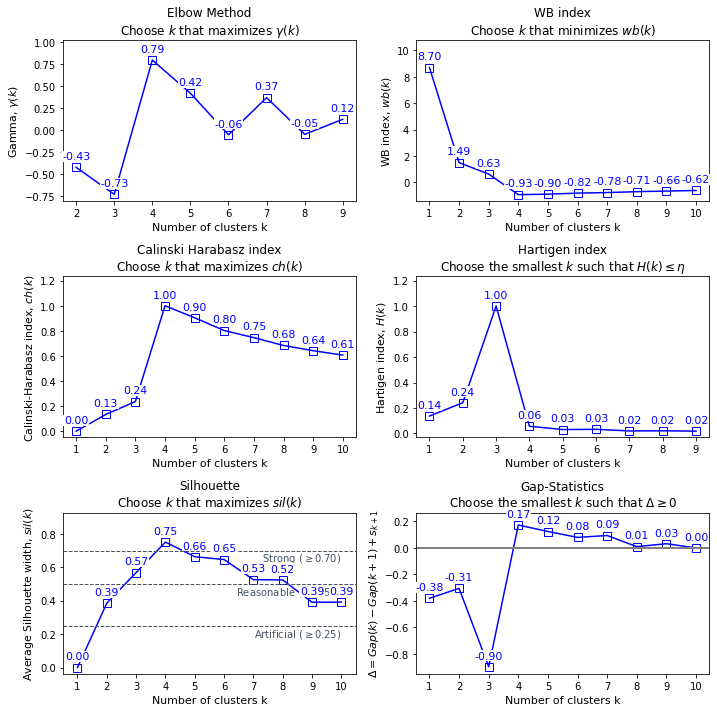

In [39]:
# Get axes to be plotted.
axes = plt.subplots(3,2,figsize=(10,10))[1].ravel()

for key,ax in zip(methods.keys(), axes):
    cal ,kwds, plot = methods[key]
    retval = (cal(data, labels) if kwds is None 
              else cal(data, labels, **kwds))
    
    # Scaling scores.
    if key in ["Calinski-Harabasz", "Hartigan"]:
        a, b = retval
        retval = (a/max(a), b)
    
    plot(retval, **(dict(ax=ax, tight_layout=False) 
                    if key!="Gap-statistic" else 
                    dict(ax=ax, tight_layout=False, ch_type=3)))
    
plt.tight_layout()
plt.show()

### <font color="green" size=5> Clustering Analysis </font>

Select parameters and method that best answer business interpretation and practicality.

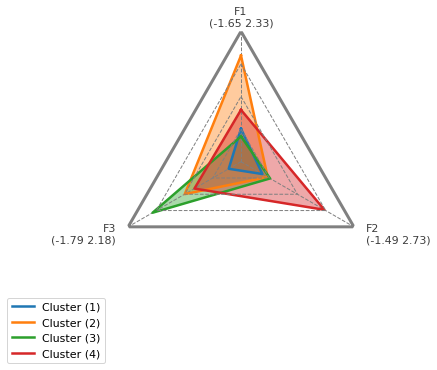

In [40]:
ax = cluster_radar(RotatedFactors, labels[:,3])

Use pairwise comparison to observe interaction of variables

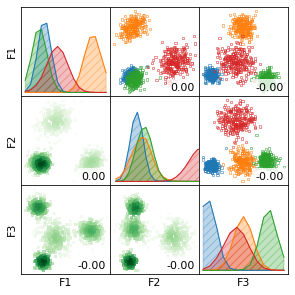

In [41]:
axes = cluster_matrix(RotatedFactors.copy(), labels[:,3],off_diagonal="both",
                      scatter_kwds=dict(cmap="Greens"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=True)

Alternatively, we can use features or other numerical variables to observe the characteristics of each cluster.

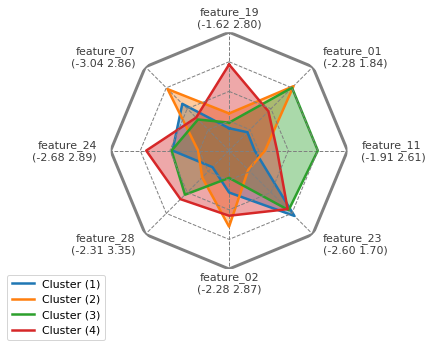

In [42]:
ax = cluster_radar(X_std, labels[:,3])

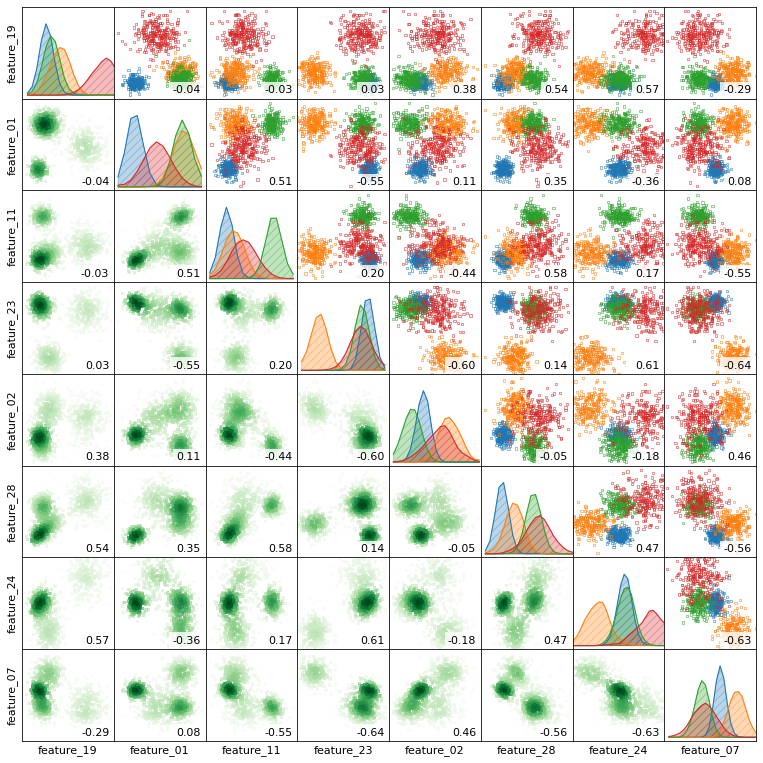

In [43]:
axes = cluster_matrix(X_std.copy(), labels[:,3],off_diagonal="both",
                      scatter_kwds=dict(cmap="Greens"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=True)

### <font color="green" size=5> Final Cluster </font>

In [44]:
final_X = pd.concat((X_std, PC, RotatedFactors), axis=1)
final_X["cluster"] = labels[:,3]

In [45]:
final_X.head(5)

,feature_19,feature_01,feature_11,feature_23,feature_02,feature_28,feature_24,feature_07,PC1,PC2,PC3,F1,F2,F3,cluster
0,0.04,1.07,1.78,0.89,-1.23,0.50,-0.13,-0.49,-1.59,0.98,-1.66,-0.87,-0.34,1.40,2
1,-0.36,0.99,1.65,0.47,-1.23,0.21,-0.58,-0.56,-1.03,0.91,-1.98,-0.75,-0.73,1.38,2
2,1.69,-0.51,-0.86,0.80,-0.71,0.53,1.03,-0.17,-1.41,-0.71,1.41,-0.41,1.18,-0.68,3
3,-0.52,0.98,1.60,0.45,-0.72,0.39,0.13,-1.11,-1.48,0.96,-1.56,-0.79,-0.33,1.34,2
4,-0.57,0.82,1.04,0.73,-1.05,1.04,0.12,-0.42,-1.40,0.73,-1.42,-0.80,-0.30,1.14,2
